In [1]:
import time
start_time = time.time()

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from CalVal import *

%matplotlib inline

field_data = ['HER', '11JUN18', '', 'Sentinel2a', 'GA_Panel', 'Radiance']
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/TMP/'
fignum=0

brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 1.0, 0.0, 0.0],
                          ['band11', 1.0, 0.0, 0.0],
                          ['band12', 1.0, 0.0, 0.0],
                          ['band2', 1.0, 0.0, 0.0],
                          ['band3', 1.0, 0.0, 0.0],
                          ['band4', 1.0, 0.0, 0.0],
                          ['band5', 1.0, 0.0, 0.0],
                          ['band6', 1.0, 0.0, 0.0],
                          ['band7', 1.0, 0.0, 0.0],
                          ['band8', 1.0, 0.0, 0.0],
                          ['band8a', 1.0, 0.0, 0.0],
                         ])
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]


In [2]:
ed = pd.read_csv('HP1.csv')
ed.set_index('Time', inplace=True)
ed.index.names = ['Wavelength']
ed.drop('576.23333', axis=1, inplace=True)
ed.drop('579.71667', axis=1, inplace=True)

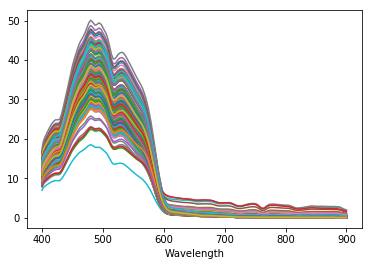

In [3]:
ed.plot(legend=False)

In [4]:
edtot = pd.read_csv('HP2.csv')
edtot.set_index('Time', inplace=True)
edtot.index.names = ['Wavelength']

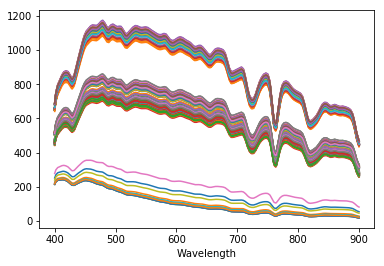

In [5]:
edtot.plot(legend=False)

In [6]:
lu = pd.read_csv('HP3.csv')

In [7]:
lu.set_index('Time', inplace=True)

In [8]:
lu.index.names = ['Wavelength']

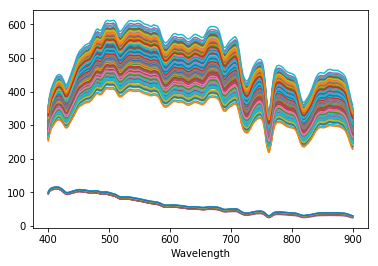

In [9]:
lu.plot(legend=False)

In [10]:
res_ed = [int(60*x) for x in ed.columns.values.astype(float)]
res_edtot = [int(60*x) for x in edtot.columns.values.astype(float)]
res_lu = [int(60*x) for x in lu.columns.values.astype(float)]

In [11]:
res12 = [a_i - b_i for a_i, b_i in zip(res_ed, res_edtot)]
res13 = [a_i - b_i for a_i, b_i in zip(res_ed, res_lu)]
res23 = [a_i - b_i for a_i, b_i in zip(res_edtot, res_lu)]


In [12]:
edtot.columns = res_edtot

In [13]:
lu.columns = res_lu

In [14]:
ed.columns = res_ed

In [15]:
edtotplus = edtot.copy()
edtotplus.columns = edtot.columns.values+1
edtotminus = edtot.copy()
edtotminus.columns = edtot.columns.values-1

edplus = ed.copy()
edplus.columns = ed.columns.values+1
edminus = ed.copy()
edminus.columns = ed.columns.values-1

### Use this cell for lu/edtot

plop = pd.DataFrame()
for i in lu.columns.values:
    try:
        plop = pd.concat([plop, lu[i]/edtot[i]], axis=1)
    except KeyError:
        try:
            plop = pd.concat([plop, lu[i]/edtotplus[i]], axis=1)
        except KeyError:
            try:
                plop = pd.concat([plop, lu[i]/edtotminus[i]], axis=1)
            except KeyError:
                continue
            continue
        continue
        
badcols = []

for i in range(len(plop.iloc[0])):
    if plop.iloc[0,i]<0.3:
        badcols.append(i)
        
plop.drop(plop.columns[badcols], axis=1, inplace=True)

badcols = []

for i in range(len(plop.iloc[0])):
    if plop.iloc[0,i]>1.0:
        badcols.append(i)
        
plop.drop(plop.columns[badcols], axis=1, inplace=True)

In [16]:
### Use this cell for ed/lu

plop = pd.DataFrame()
for i in lu.columns.values:
    try:
        plop = pd.concat([plop, ed[i]/lu[i]], axis=1)
    except KeyError:
        try:
            plop = pd.concat([plop, edplus[i]/lu[i]], axis=1)
        except KeyError:
            try:
                plop = pd.concat([plop, edminus[i]/lu[i]], axis=1)
            except KeyError:
                continue
            continue
        continue
        
badcols = []

for i in range(len(plop.iloc[0])):
    if plop.iloc[0,i]>0.08:
        badcols.append(i)
        
plop.drop(plop.columns[badcols], axis=1, inplace=True)

In [17]:
for i in range(901, 2501):
    plop.loc[i] = plop.loc[900]
for i in range(350, 399):
    plop.loc[i] = plop.loc[400]

In [18]:
median = plop.median(axis=1)

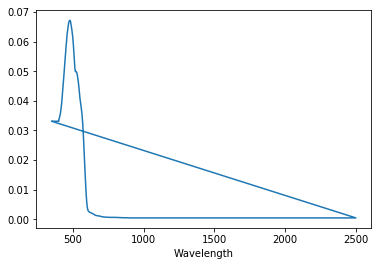

In [21]:
median.plot()

In [22]:
result_df, band = ApplyWeights.apply_weights(f_name, plop)

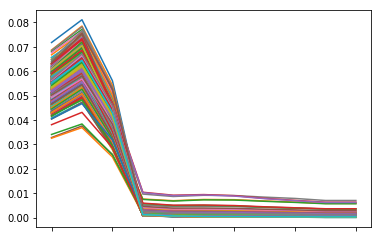

In [23]:
result_df.T.plot(legend=False)

In [24]:
result_df['Latitude'] = -23.435776 
result_df['Longitude'] = 151.998163
result_df['Line'] = 1
result_df['date_saved'] = datetime(2018, 6, 21, 23, 45, 34)

In [25]:
gps_data = pd.read_csv('ff2.txt')
gps_data.set_index('time', inplace=True)

for i in range(len(plop.columns.values)-1):
    for j in range(len(gps_data.index)):
        if plop.columns.values[i] <= gps_data.index[j]:
            result_df['Latitude'][i] = gps_data.latitude.iloc[j]
            result_df['Longitude'][i] = gps_data.longitude.iloc[j]
            break
    if plop.columns.values[i] > gps_data.index[-1]:
        result_df['Latitude'][i] = gps_data.latitude.iloc[-1]
        result_df['Longitude'][i] = gps_data.longitude.iloc[-1]

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [27]:
from CalVal.SolarAngle import solang
result_df['Solar_angle'] = result_df.apply(solang, axis=1)

In [28]:
PrintBRDF.print_brdf(result_df, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-06-21 23:45:34'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(151.998163, -23.4383522, 151.99998530000002, -23.435776)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



In [29]:
ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, result_df, field_data)

In [30]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

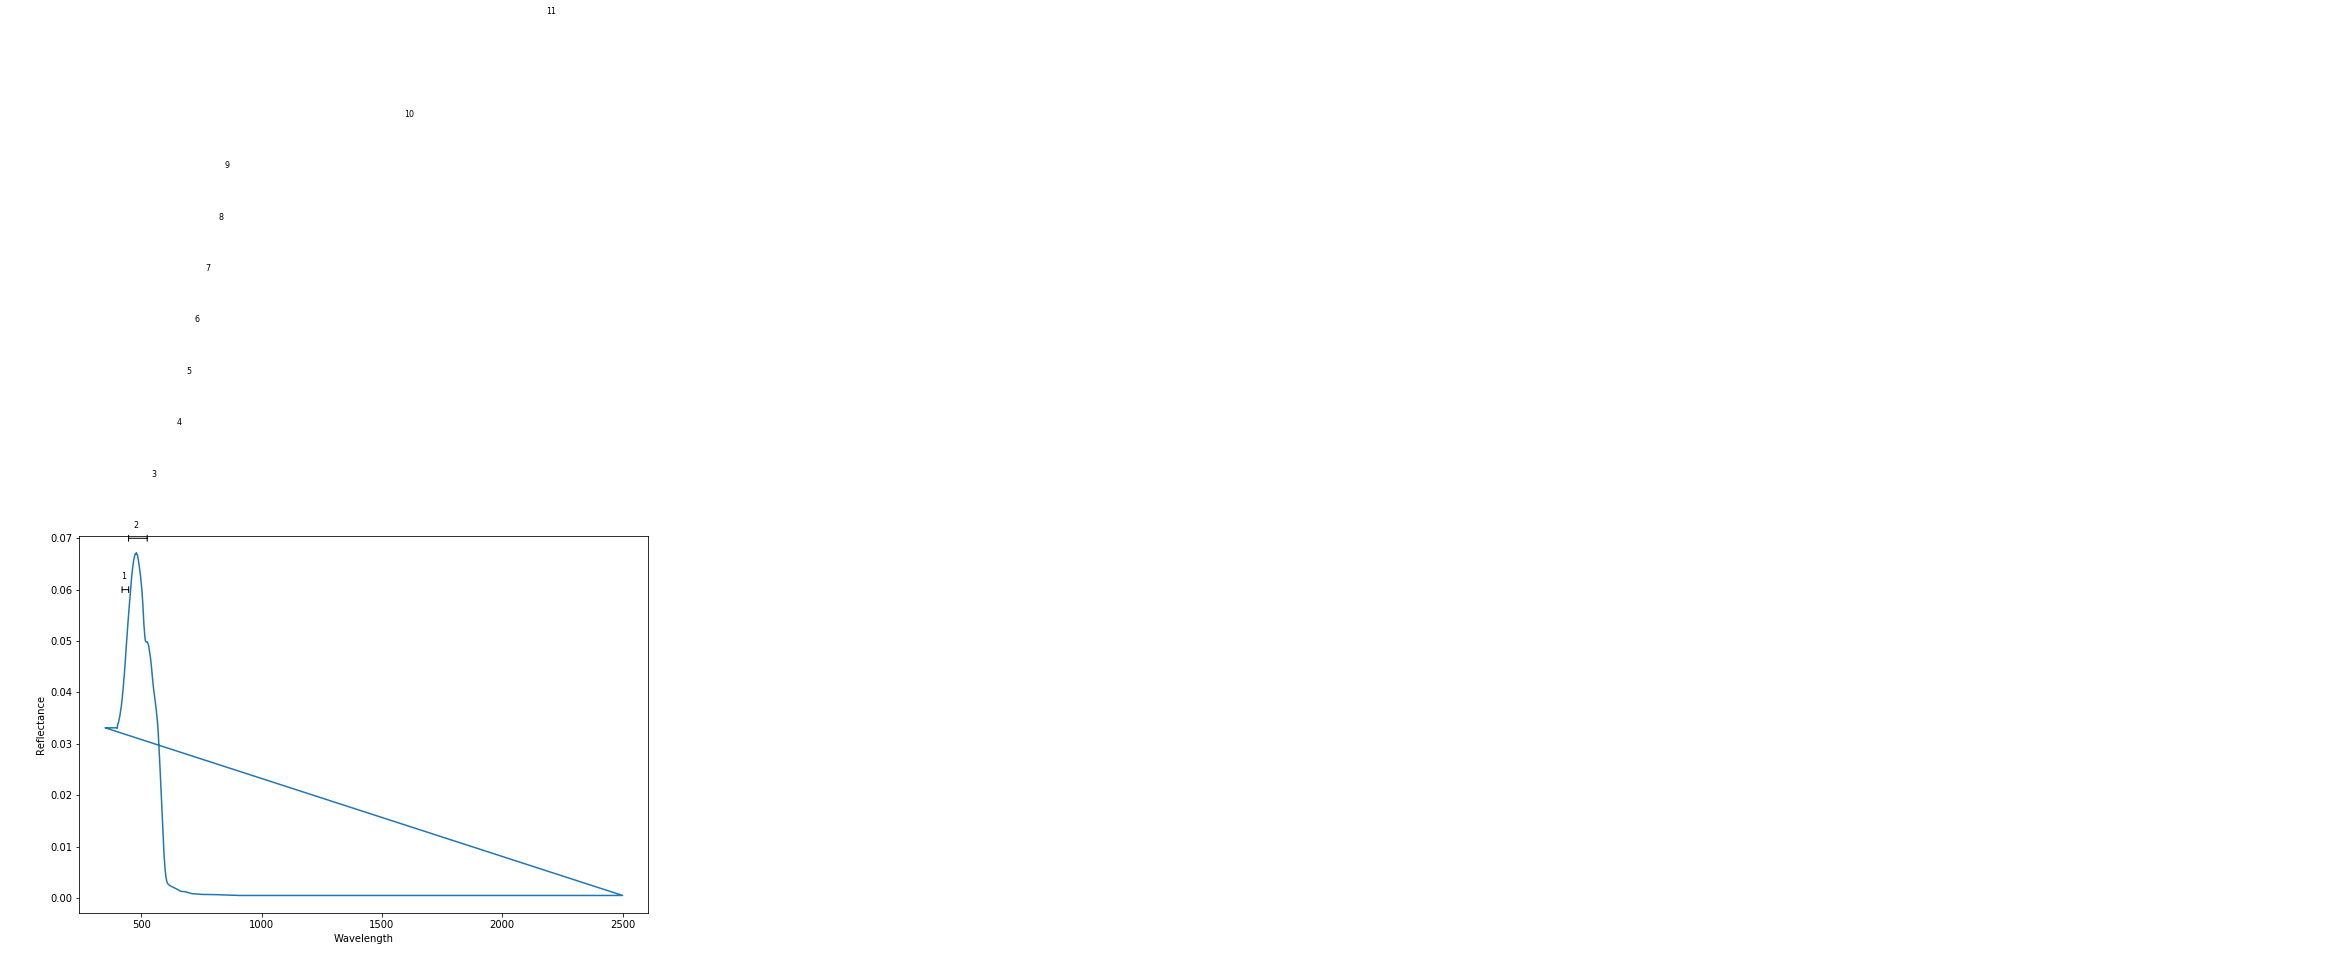

In [31]:
FIG_BandExtents.FIG_band_extents(plop, band_min, band_max, output, field_data, fignum)
fignum += 1

In [32]:
dc, query, query2 = Query.make_query(ground_brdf, field_data)

sat_array, sat_bigarray = CreateSatArrays.create_sat_arrays(dc, query, query2, field_data)

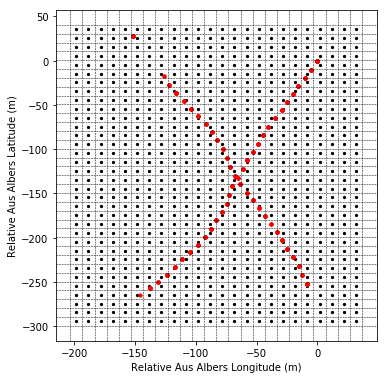

In [33]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf, sat_array, colpac, output, field_data, fignum)
fignum +=1

In [34]:
field_array = CreateFieldFromSat.create_field_from_sat(sat_array, ground_brdf, xloc, field_data)

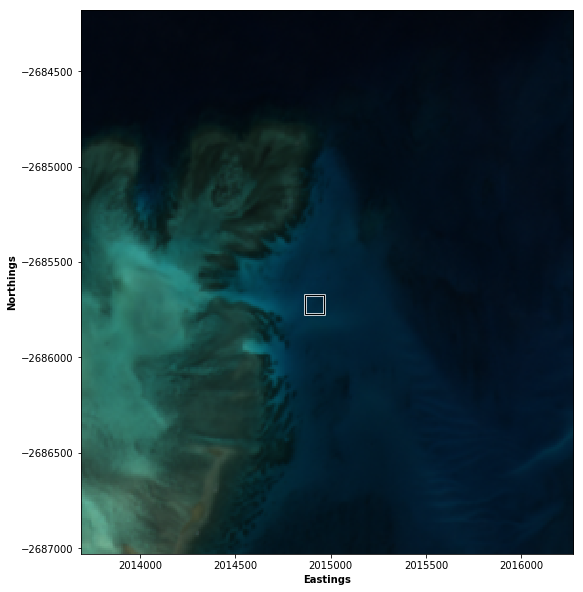

In [35]:
FIG_SatBigRGB.FIG_sat_bigRGB(sat_array, sat_bigarray, output, field_data, fignum)
fignum += 1

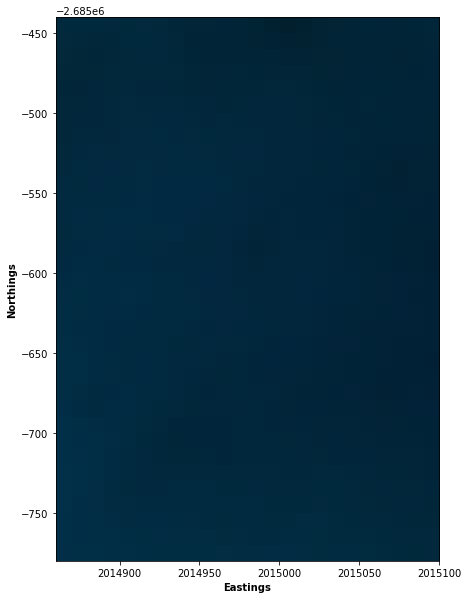

In [36]:
FIG_SatRGB.FIG_sat_RGB(sat_array, output, field_data, fignum)
fignum += 1

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


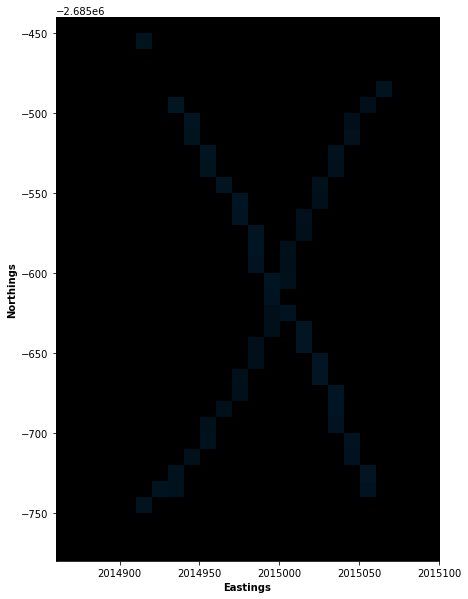

In [37]:
FIG_FieldRGB.FIG_field_RGB(field_array, output, field_data, fignum)
fignum += 1

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/_collections_abc.py:761: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


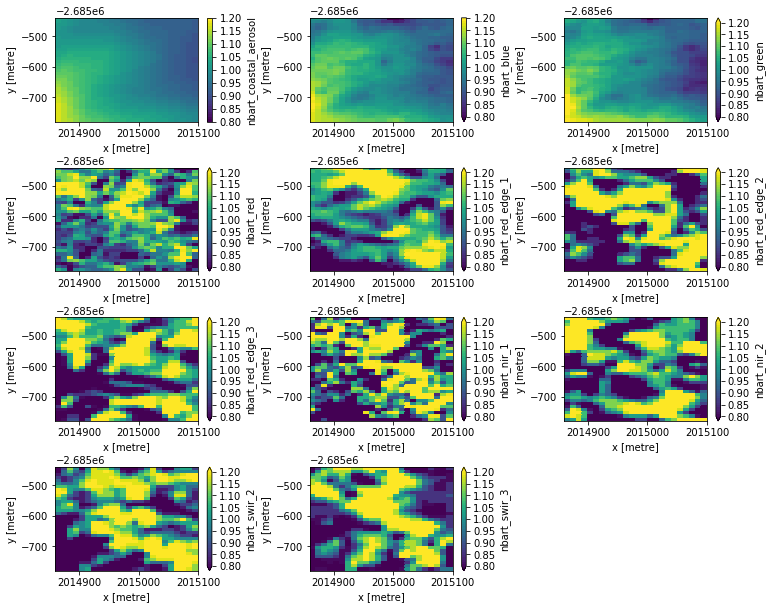

In [38]:
variance = FIG_SatBands.FIG_sat_bands(sat_array, field_array, output, field_data, fignum)
fignum += 1

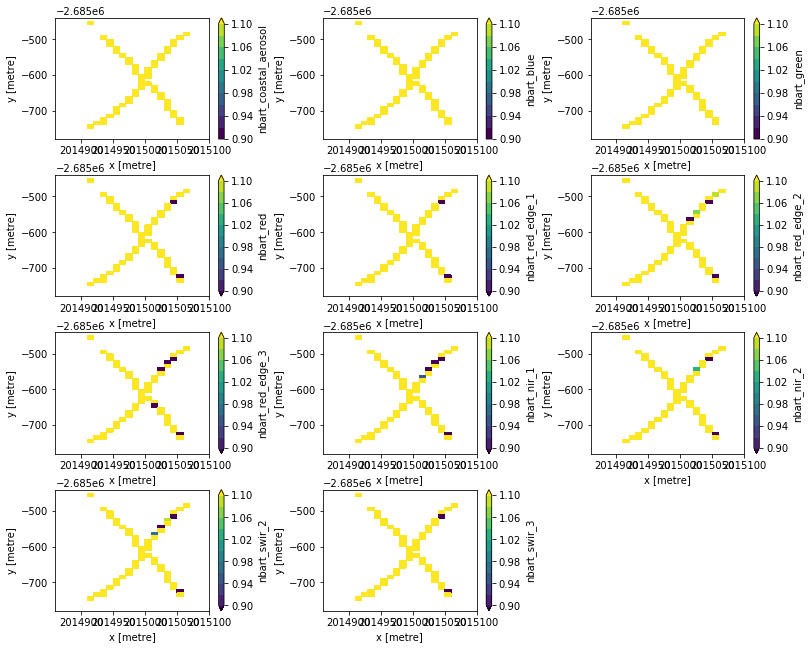

In [39]:
FIG_RatioArrays.FIG_ratio_arrays(sat_array, field_array, output, field_data, fignum)
fignum += 1

In [40]:
fstat_df = CreateStats.create_stats(sat_array, ground_brdf, field_data)

In [41]:
finner_df = CreateSubStats.create_SUB_stats(sat_array, field_array, ground_brdf, fstat_df, field_data)

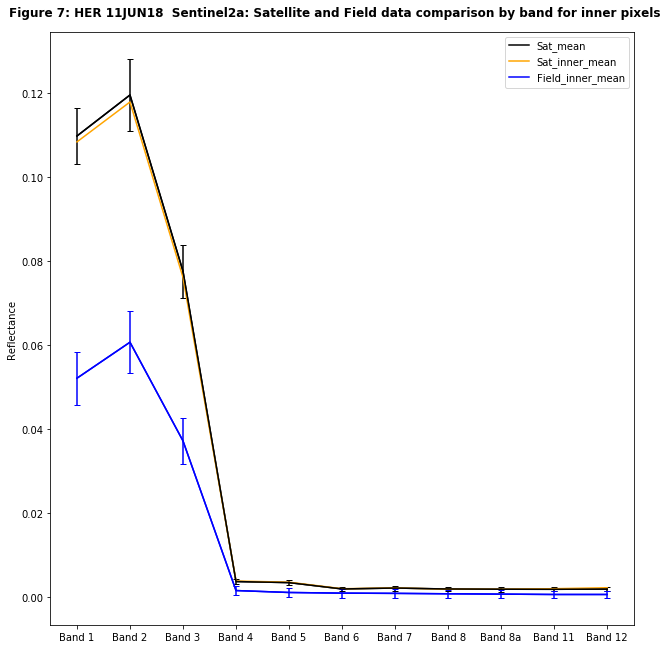

In [42]:
FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(sat_array, fstat_df, finner_df, output, field_data, fignum)
fignum += 1

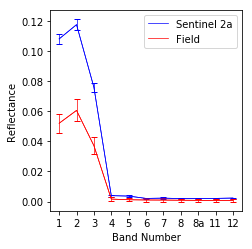

In [43]:
FIG_SatFieldBands.FIG_sat_field_bands(sat_array, fstat_df, finner_df, output, field_data, fignum)
fignum += 1

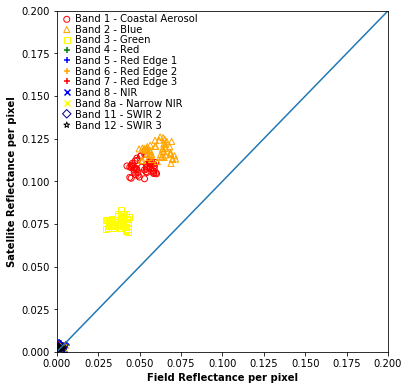

In [44]:
plot_scale = [0.0, 0.2, 0.0, 0.2]
FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum)
fignum += 1

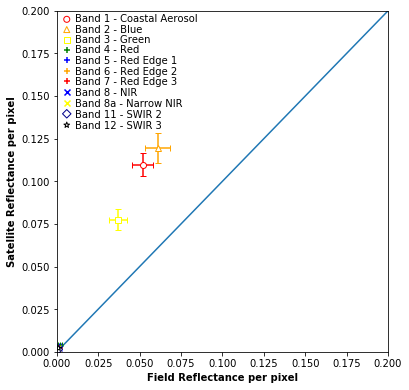

In [45]:
FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum)
fignum += 1

In [46]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:13:28 (h:m:s) to run


In [47]:
sat_array

<xarray.Dataset>
Dimensions:                (time: 1, x: 24, y: 34)
Coordinates:
  * time                   (time) datetime64[ns] 2018-06-19T00:02:41.024000
  * y                      (y) float64 -2.685e+06 -2.685e+06 -2.685e+06 ...
  * x                      (x) float64 2.015e+06 2.015e+06 2.015e+06 ...
Data variables:
    nbart_coastal_aerosol  (time, y, x) int16 1139 1127 1114 1101 1088 1083 ...
    nbart_blue             (time, y, x) int16 1199 1208 1198 1178 1196 1222 ...
    nbart_green            (time, y, x) int16 809 816 804 793 806 813 786 ...
    nbart_red              (time, y, x) int16 38 34 33 35 38 40 41 42 43 45 ...
    nbart_red_edge_1       (time, y, x) int16 37 38 39 40 42 43 44 45 45 39 ...
    nbart_red_edge_2       (time, y, x) int16 19 22 23 23 23 25 27 22 18 17 ...
    nbart_red_edge_3       (time, y, x) int16 28 26 24 23 23 23 23 23 24 24 ...
    nbart_nir_1            (time, y, x) int16 22 16 19 23 17 19 20 15 13 15 ...
    nbart_nir_2            (time, y, x) 

In [50]:
fstat_df.to_csv('HER_temp.csv')